# Case de Telemedicina e Data Science - Analise Cohort
Este notebook tem o objetivo de analisar a base de clientes e propor ações para aumentar o tempo que o usuário permanece sendo assinante do serviço. Para isso será realizada uma análise cohort a fim de identificar quais cohorts tem maior engajamento.

## Critérios para o cohort
1. Criar período para a data da consulta
1. Determinar o grupo cohort baseado na data da primeira consulta
1. Agregar dados por grupo de cohort e periodo da consulta
1. Nomear os períodos dentro de cada grupo de cohort


## Base de dados

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

In [2]:
dateparse = lambda x: pd.datetime.strptime(x, '%d/%m/%y')
appointments = pd.read_csv('dataset/appointments.csv'
                           ,parse_dates = ['appointment_date']
                           ,date_parser = dateparse)
nps = pd.read_csv('dataset/nps.csv')
users = pd.read_csv('dataset/users.csv'
                           ,parse_dates = ['birth_date', 'start_date', 'end_date']
                           ,date_parser = dateparse)

/Users/victordesanunes/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """Entry point for launching an IPython kernel.


In [3]:
cohort_dataset = appointments.merge(users)
# Cria o periodo do cohort
cohort_dataset['period'] = cohort_dataset["appointment_date"].dt.strftime("%Y-%m")
cohort_dataset

,appt_id,user_id,appointment_date,channel,type,gender,birth_date,start_date,end_date,city_code,period
0,1,1,2010-08-10,chat,first,female,1981-07-07,2010-06-29,2010-11-02,3,2010-08
1,2,1,2010-10-29,chat,regular,female,1981-07-07,2010-06-29,2010-11-02,3,2010-10
2,3,2,2011-06-18,presential,first,male,1996-10-08,2011-01-18,2012-02-18,1,2011-06
3,4,2,2011-10-24,chat,regular,male,1996-10-08,2011-01-18,2012-02-18,1,2011-10
4,5,2,2011-12-29,chat,regular,male,1996-10-08,2011-01-18,2012-02-18,1,2011-12
...,...,...,...,...,...,...,...,...,...,...,...
2685,2686,462,2013-06-18,presential,regular,male,1984-03-27,2011-01-14,2013-06-29,3,2013-06
2686,2687,462,2012-06-27,presential,regular,male,1984-03-27,2011-01-14,2013-06-29,3,2012-06
2687,2688,462,2012-10-16,chat,regular,male,1984-03-27,2011-01-14,2013-06-29,3,2012-10
2688,2689,463,2010-09-14,chat,first,female,1995-12-31,2010-09-05,2011-03-26,3,2010-09


In [4]:
cohort_dataset.set_index('user_id', inplace=True)

# Determina qual cohort o usuario deve pertencer
cohort_dataset['cohort_group'] = cohort_dataset.groupby(level=0)['appointment_date'].min().apply(lambda x: x.strftime('%Y-%m'))
cohort_dataset.reset_index(inplace=True)
cohort_dataset.head()

,user_id,appt_id,appointment_date,channel,type,gender,birth_date,start_date,end_date,city_code,period,cohort_group
0,1,1,2010-08-10,chat,first,female,1981-07-07,2010-06-29,2010-11-02,3,2010-08,2010-08
1,1,2,2010-10-29,chat,regular,female,1981-07-07,2010-06-29,2010-11-02,3,2010-10,2010-08
2,2,3,2011-06-18,presential,first,male,1996-10-08,2011-01-18,2012-02-18,1,2011-06,2011-06
3,2,4,2011-10-24,chat,regular,male,1996-10-08,2011-01-18,2012-02-18,1,2011-10,2011-06
4,2,5,2011-12-29,chat,regular,male,1996-10-08,2011-01-18,2012-02-18,1,2011-12,2011-06


In [5]:
import numpy as np

# Agrega dados dos usuarios de cada cohort
grouped = cohort_dataset.groupby(['cohort_group', 'period'])

cohorts = grouped.agg({'user_id': pd.Series.nunique,
                       'appt_id': pd.Series.nunique})

cohorts.rename(columns={'user_id': 'total_users',
                        'appt_id': 'total_appt'}, inplace=True)
cohorts.head(15)

total_users  total_appt
cohort_group period                          
2010-01      2010-01            4           4
             2010-02            2           2
             2010-03            1           1
             2010-04            2           2
             2010-05            2           2
             2010-06            1           1
             2010-07            1           1
             2010-08            2           3
             2010-09            1           1
             2010-10            1           1
             2010-12            1           1
             2011-03            1           1
             2011-04            1           1
             2011-06            1           1
             2011-07            1           1

In [6]:
def cohort_period(df):
    """
    Creates a `CohortPeriod` column, which is the Nth period based on the user's first purchase.
    
    Example
    -------
    Say you want to get the 3rd month for every user:
        df.sort(['UserId', 'OrderTime', inplace=True)
        df = df.groupby('UserId').apply(cohort_period)
        df[df.CohortPeriod == 3]
    """
    df['CohortPeriod'] = np.arange(len(df)) + 1
    return df

cohorts = cohorts.groupby(level=0).apply(cohort_period)
cohorts.head()

total_users  total_appt  CohortPeriod
cohort_group period                                        
2010-01      2010-01            4           4             1
             2010-02            2           2             2
             2010-03            1           1             3
             2010-04            2           2             4
             2010-05            2           2             5

In [7]:
cohorts.reset_index(inplace=True)
cohorts.set_index(['cohort_group', 'period'], inplace=True)

# create a Series holding the total size of each CohortGroup
cohort_group_size = cohorts['total_users'].groupby(level=0).first()
cohort_group_size.head()

cohort_group
2010-01     4
2010-02    14
2010-03    13
2010-04    11
2010-05    22
Name: total_users, dtype: int64

In [8]:
cohorts['total_users'].unstack(0).head()

cohort_group,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,2010-10,...,2011-11,2011-12,2012-01,2012-02,2012-03,2012-04,2012-05,2012-06,2012-08,2012-09
period,,,,,,,,,,,,,,,,,,,,,
2010-01,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-02,2.0,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-03,1.0,3.0,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-04,2.0,5.0,3.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-05,2.0,4.0,3.0,5.0,22.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# Matriz com a taxa de retencao de cada cohort ao longo de todos os periodos
user_interaction = cohorts['total_users'].unstack(0).divide(cohort_group_size, axis=1).fillna(0)
user_interaction.head(15)

cohort_group,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,2010-10,...,2011-11,2011-12,2012-01,2012-02,2012-03,2012-04,2012-05,2012-06,2012-08,2012-09
period,,,,,,,,,,,,,,,,,,,,,
2010-01,1.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-02,0.50,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-03,0.25,0.214286,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-04,0.50,0.357143,0.230769,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-05,0.50,0.285714,0.230769,0.454545,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-06,0.25,0.000000,0.153846,0.363636,0.136364,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-07,0.25,0.285714,0.230769,0.363636,0.318182,0.444444,1.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-08,0.50,0.214286,0.076923,0.272727,0.227273,0.166667,0.352941,1.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-09,0.25,0.142857,0.153846,0.272727,0.363636,0.277778,0.176471,0.421053,1.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


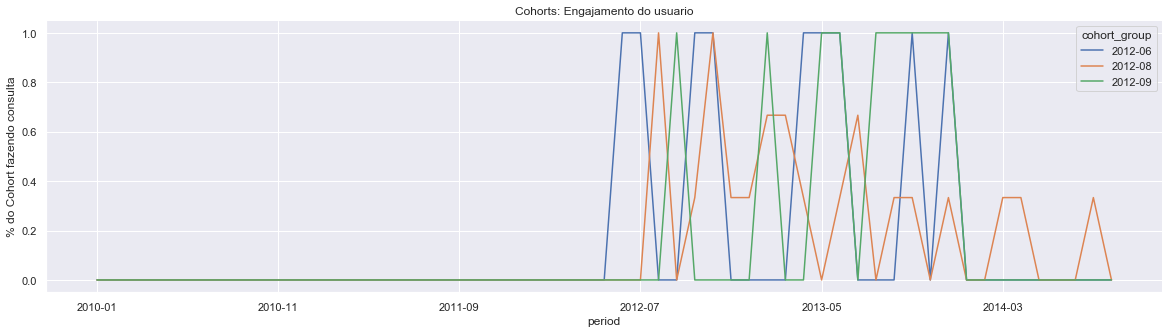

In [10]:
sns.set()
# sns.set_palette(palette = sns.color_palette("coolwarm", 7))
user_interaction[['2012-06', '2012-08', '2012-09']].plot(figsize=(20,5), )
plt.title('Cohorts: Engajamento do usuario')
plt.ylabel('% do Cohort fazendo consulta');
sns.despine()

## Métricas de negócio
- Tempo de permancencia na plataforma
- Tempo até a primeira consulta

> # Tempo de permanencia na plataforma

Por quanto tempo cada usuario permanceu com contrato ativo

In [11]:
users['active_time_days'] = (users['end_date'] - users['start_date'])

In [12]:
appointments

,appt_id,user_id,appointment_date,channel,type
0,1,1,2010-08-10,chat,first
1,2,1,2010-10-29,chat,regular
2,3,2,2011-06-18,presential,first
3,4,2,2011-10-24,chat,regular
4,5,2,2011-12-29,chat,regular
...,...,...,...,...,...
2685,2686,462,2013-06-18,presential,regular
2686,2687,462,2012-06-27,presential,regular
2687,2688,462,2012-10-16,chat,regular
2688,2689,463,2010-09-14,chat,first


In [13]:
appointment_augmented = appointments.merge(users).merge(nps)
appointment_augmented['active_time_until_appt'] = appointment_augmented['appointment_date'] - appointment_augmented['start_date']
appointment_augmented['age_at_activation'] = appointment_augmented['start_date'] - appointment_augmented['birth_date']
appointment_augmented

,appt_id,user_id,appointment_date,channel,type,gender,birth_date,start_date,end_date,city_code,active_time_days,nps,active_time_until_appt,age_at_activation
0,1,1,2010-08-10,chat,first,female,1981-07-07,2010-06-29,2010-11-02,3,126 days,9,42 days,10584 days
1,2,1,2010-10-29,chat,regular,female,1981-07-07,2010-06-29,2010-11-02,3,126 days,9,122 days,10584 days
2,3,2,2011-06-18,presential,first,male,1996-10-08,2011-01-18,2012-02-18,1,396 days,5,151 days,5215 days
3,4,2,2011-10-24,chat,regular,male,1996-10-08,2011-01-18,2012-02-18,1,396 days,5,279 days,5215 days
4,5,2,2011-12-29,chat,regular,male,1996-10-08,2011-01-18,2012-02-18,1,396 days,5,345 days,5215 days
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2685,2686,462,2013-06-18,presential,regular,male,1984-03-27,2011-01-14,2013-06-29,3,897 days,3,886 days,9789 days
2686,2687,462,2012-06-27,presential,regular,male,1984-03-27,2011-01-14,2013-06-29,3,897 days,3,530 days,9789 days
2687,2688,462,2012-10-16,chat,regular,male,1984-03-27,2011-01-14,2013-06-29,3,897 days,3,641 days,9789 days
2688,2689,463,2010-09-14,chat,first,female,1995-12-31,2010-09-05,2011-03-26,3,202 days,3,9 days,5362 days


In [14]:
appointment_augmented['age_at_activation'] = appointment_augmented['age_at_activation'].dt.days/365
appointment_augmented['age_at_activation'] = appointment_augmented['age_at_activation'].apply(lambda x: int(x))
appointment_augmented

,appt_id,user_id,appointment_date,channel,type,gender,birth_date,start_date,end_date,city_code,active_time_days,nps,active_time_until_appt,age_at_activation
0,1,1,2010-08-10,chat,first,female,1981-07-07,2010-06-29,2010-11-02,3,126 days,9,42 days,28
1,2,1,2010-10-29,chat,regular,female,1981-07-07,2010-06-29,2010-11-02,3,126 days,9,122 days,28
2,3,2,2011-06-18,presential,first,male,1996-10-08,2011-01-18,2012-02-18,1,396 days,5,151 days,14
3,4,2,2011-10-24,chat,regular,male,1996-10-08,2011-01-18,2012-02-18,1,396 days,5,279 days,14
4,5,2,2011-12-29,chat,regular,male,1996-10-08,2011-01-18,2012-02-18,1,396 days,5,345 days,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2685,2686,462,2013-06-18,presential,regular,male,1984-03-27,2011-01-14,2013-06-29,3,897 days,3,886 days,26
2686,2687,462,2012-06-27,presential,regular,male,1984-03-27,2011-01-14,2013-06-29,3,897 days,3,530 days,26
2687,2688,462,2012-10-16,chat,regular,male,1984-03-27,2011-01-14,2013-06-29,3,897 days,3,641 days,26
2688,2689,463,2010-09-14,chat,first,female,1995-12-31,2010-09-05,2011-03-26,3,202 days,3,9 days,14


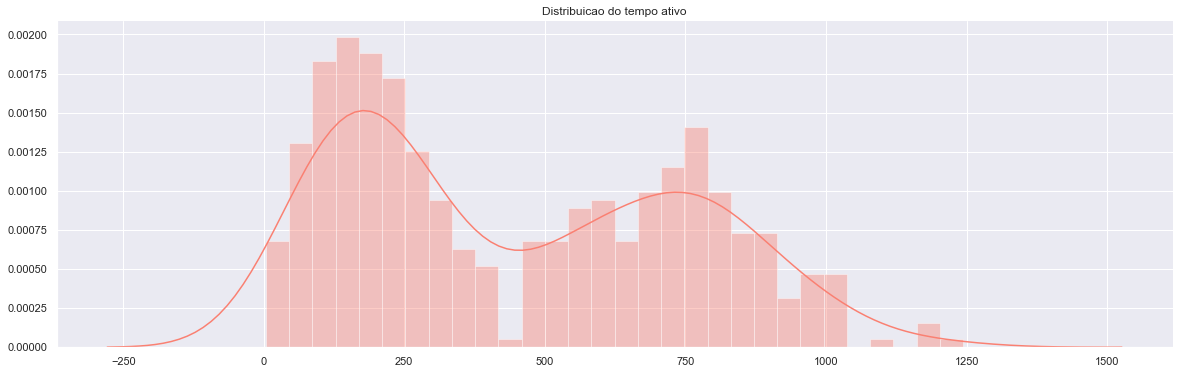

In [15]:
acitve_days = users['end_date'] - users['start_date']
_ = plt.figure(figsize=(20, 6))
_ = plt.title('Distribuicao do tempo ativo')
_ = sns.distplot(acitve_days.dt.days, bins = 30, color = 'salmon')
sns.despine()

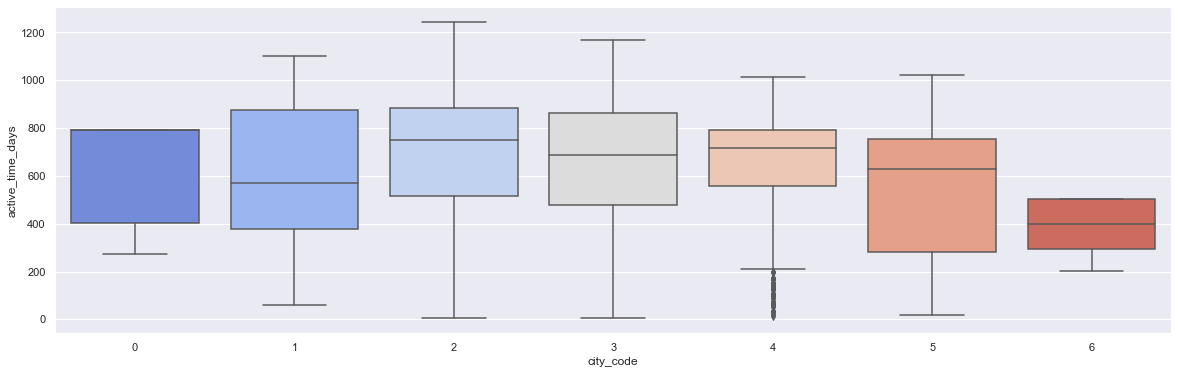

In [16]:
_ = plt.figure(figsize=(20, 6))
_ = sns.boxplot(x = appointment_augmented['city_code'], 
                y = appointment_augmented['active_time_days'].dt.days
                ,palette = sns.color_palette("coolwarm", 7)
#                 ,color = 'salmon
               )

In [17]:
appointment_augmented[['active_time_days', 'nps', 'active_time_until_appt', 'age_at_activation']].describe()

,active_time_days,nps,active_time_until_appt,age_at_activation
count,2690,2690.000000,2690,2690.000000
mean,651 days 10:18:49.516728,6.518587,334 days 19:49:28.327137,19.193309
std,264 days 22:33:56.419281,2.629436,247 days 07:36:00.565024,6.199410
min,4 days 00:00:00,1.000000,0 days 00:00:00,8.000000
25%,494 days 00:00:00,4.000000,125 days 00:00:00,14.000000
50%,711 days 00:00:00,7.000000,291 days 00:00:00,19.000000
75%,841 days 00:00:00,9.000000,511 days 18:00:00,25.000000
max,1244 days 00:00:00,10.000000,1206 days 00:00:00,30.000000
